Resumo dos Hiperparâmetros Utilizados (Experimento Final)
1. Parâmetros do Dataset e Treinamento
Arquitetura do Modelo: U-Net
Tamanho da Imagem: 256 x 256 pixels
Tamanho do Lote (Batch Size): 4 imagens por iteração
Número de Épocas (Epochs): 75 (duração máxima do treinamento)
2. Parâmetros de Otimização
Função de Perda (Loss Function): DiceBCELoss (uma combinação de Binary Cross-Entropy e Dice Loss, robusta para segmentação e classes desbalanceadas).
Otimizador (Optimizer): Adam
Taxa de Aprendizado Inicial (Initial Learning Rate): 1e-4 (ou 0.0001)
3. Parâmetros do Agendador de Taxa de Aprendizado (Learning Rate Scheduler)
Estratégia: ReduceLROnPlateau (Reduzir a taxa de aprendizado quando a métrica para de melhorar).
Métrica Monitorada: IoU de Validação (o scheduler age com base nesta métrica).
Fator de Redução: 0.2 (a nova taxa de aprendizado será antiga * 0.2).
Paciência (Patience): 5 épocas (número de épocas a esperar por uma melhora antes de reduzir a taxa de aprendizado).
Taxa de Aprendizado Mínima (Min LR): 1e-7 (o scheduler não reduzirá a taxa para valores abaixo deste).

In [1]:
# CELULA 1
# Importar as bibliotecas necessárias
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import concurrent.futures
import csv
import pandas as pd
import seaborn as sns

In [2]:
# CELULA 2
# Defina os caminhos
SOURCE_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data"
TARGET_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256" # Nova pasta
TARGET_SIZE = (256, 256)

# print(f"Criando nova estrutura de pastas em: {TARGET_DATA_DIR}")
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/masks"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/masks"), exist_ok=True)

# def process_single_image(args):
#     filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder = args
#     try:
#         with Image.open(os.path.join(source_img_folder, filename)) as img:
#             img_resized = img.resize(TARGET_SIZE, Image.LANCZOS)
#             img_resized.save(os.path.join(target_img_folder, filename))

#         mask_filename = filename.replace(".jpg", ".png")
#         mask_path = os.path.join(source_mask_folder, mask_filename)
#         if not os.path.exists(mask_path):
#             mask_path = os.path.join(source_mask_folder, filename) # Tenta o mesmo nome

#         with Image.open(mask_path) as mask:
#             mask_resized = mask.resize(TARGET_SIZE, Image.NEAREST)
#             mask_resized.save(os.path.join(target_mask_folder, mask_filename))
#     except Exception as e:
#         print(f"Erro ao processar {filename}: {e}")

# def preprocess_dataset(subset):
#     print(f"\nProcessando o conjunto de dados: {subset}")
#     source_img_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/images")
#     source_mask_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/masks")
#     target_img_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/images")
#     target_mask_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/masks")
#     image_files = os.listdir(source_img_folder)

#     args_list = [
#         (filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder)
#         for filename in image_files
#     ]

#     with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
#         list(tqdm(executor.map(process_single_image, args_list), total=len(args_list), desc=f"Redimensionando {subset} images"))

# # Executar para treino e validação
# preprocess_dataset("train")
# preprocess_dataset("validation")

# print("\nPré-processamento concluído!")

In [3]:
# CELULA 3
# --- Configurações do Ambiente e Caminhos ---
# Certifique-se de que este caminho aponta para os dados pré-processados
DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256_augumentation" 
MODEL_SAVE_PATH = "./tomato_unet_best.pth"  # O modelo será salvo com este nome
CSV_LOG_PATH = "./training_log.csv"      # O log será salvo aqui
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {DEVICE}")

# --- Hiperparâmetros para o Treinamento v2 ---
config = {
    "LEARNING_RATE": 1e-4,       # LR inicial. O scheduler vai ajustá-lo.
    "BATCH_SIZE": 4,
    "NUM_EPOCHS": 100,            
    "IMAGE_HEIGHT": 256,
    "IMAGE_WIDTH": 256,
    "OPTIMIZER": "Adam",
    "LOSS_FUNCTION": "DiceBCE"
}

# NOVO: Configuração do Agendador de Taxa de Aprendizado (Scheduler)
scheduler_config = {
    "factor": 0.2,               # Fator de redução do LR (new_lr = lr * factor). 0.1 ou 0.2 são comuns.
    "patience": 5,               # Nº de épocas sem melhora no val_iou para reduzir o LR.
    "min_lr": 1e-7,              # Taxa de aprendizado mínima.
    "verbose": True              # Imprime uma mensagem quando o LR é atualizado.
}

Usando o dispositivo: cuda


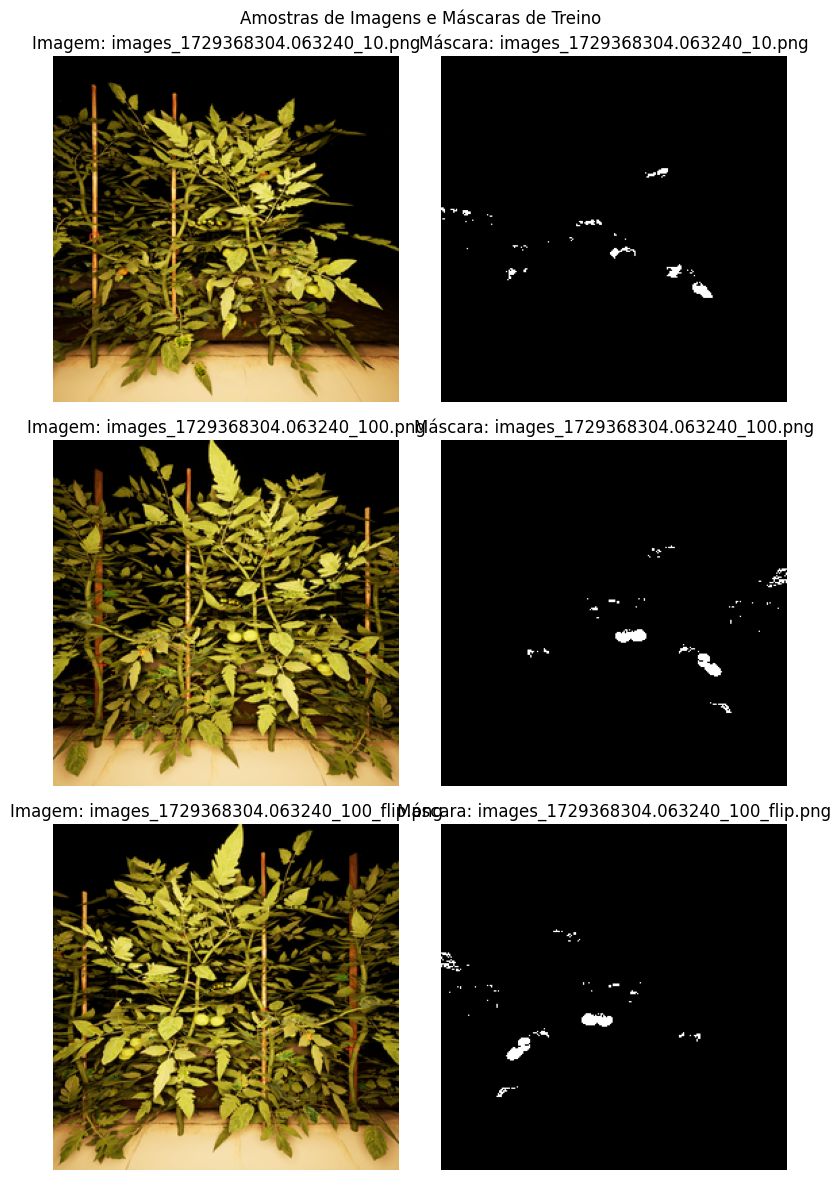

Analisando a proporção de pixels de 'tomate' nas máscaras de treino...


100%|██████████| 100/100 [00:00<00:00, 300.62it/s]


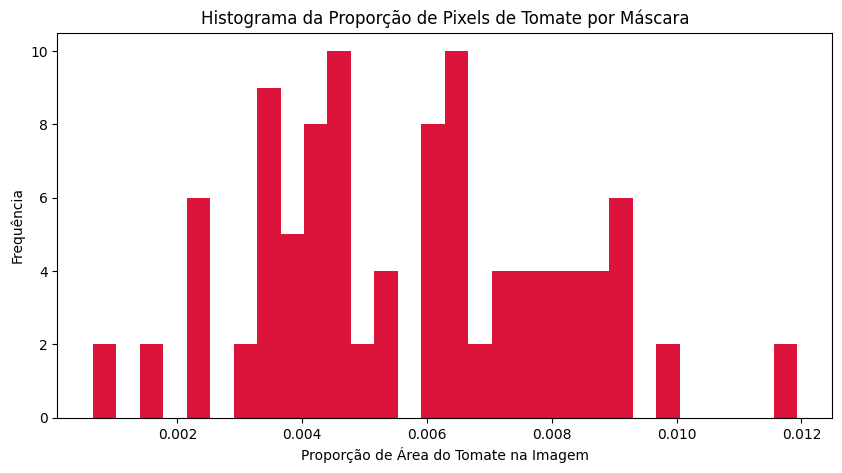

Análise concluída. Média da proporção (em imagens com tomates): 0.0057


In [4]:
# CELULA 4
# a) Pré-processamento, análise estatística dos dados, visualização

# Vamos visualizar algumas imagens e máscaras para entender os dados
train_img_dir = os.path.join(DATA_DIR, "train/images")
train_mask_dir = os.path.join(DATA_DIR, "train/masks")

# Pegar uma lista de imagens (assumindo que os nomes correspondem)
sample_images = os.listdir(train_img_dir)[:3]

fig, axs = plt.subplots(len(sample_images), 2, figsize=(8, 12))
fig.suptitle('Amostras de Imagens e Máscaras de Treino')

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(train_img_dir, img_name)
    # Assumindo que a máscara tem o mesmo nome, mas talvez extensão diferente
    # Tente .png ou .jpg se necessário
    mask_path = os.path.join(train_mask_dir, img_name.replace('.jpg', '.png'))
    if not os.path.exists(mask_path):
        mask_path = os.path.join(train_mask_dir, img_name)


    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L") # Converter para tons de cinza

    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f"Imagem: {img_name}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title(f"Máscara: {os.path.basename(mask_path)}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Análise Estatística Simples: Proporção de pixels de tomate
print("Analisando a proporção de pixels de 'tomate' nas máscaras de treino...")
mask_files = os.listdir(train_mask_dir)
tomato_proportions = []
for mask_file in tqdm(mask_files[:100]): # Analisar as primeiras 100 para ser rápido
    mask_path = os.path.join(train_mask_dir, mask_file)
    mask_np = np.array(Image.open(mask_path).convert("L"))
    proportion = np.sum(mask_np > 128) / (mask_np.shape[0] * mask_np.shape[1])
    if proportion > 0: # Apenas se houver tomate
        tomato_proportions.append(proportion)

plt.figure(figsize=(10, 5))
plt.hist(tomato_proportions, bins=30, color='crimson')
plt.title('Histograma da Proporção de Pixels de Tomate por Máscara')
plt.xlabel('Proporção de Área do Tomate na Imagem')
plt.ylabel('Frequência')
plt.show()
print(f"Análise concluída. Média da proporção (em imagens com tomates): {np.mean(tomato_proportions):.4f}")

In [5]:
# CELULA 5
# Classe customizada para carregar os dados
class TomatoDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.image_dir, img_name)

        # Tratar extensões diferentes entre imagem e máscara
        mask_name = img_name
        possible_mask_exts = ['.png', '.jpg', '.jpeg']
        for ext in possible_mask_exts:
            if mask_name.endswith(ext):
                base_name = mask_name[:-len(ext)]
                break
        else:
            base_name = mask_name

        mask_path = None
        for ext in possible_mask_exts:
            potential_path = os.path.join(self.mask_dir, base_name + ext)
            if os.path.exists(potential_path):
                mask_path = potential_path
                break

        if mask_path is None:
            # Tenta com o mesmo nome exato se falhar
             mask_path = os.path.join(self.mask_dir, img_name)
             if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Não foi possível encontrar a máscara para a imagem {img_name}")


        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        # Normalizar máscara para 0.0-1.0
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

# Definir transformações (redimensionamento e conversão para tensor)
# Para data augmentation, pode-se usar a biblioteca Albumentations
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# Por simplicidade, usaremos torchvision transforms
NUM_WORKERS = 0 # <<<< COMECE COM ESTE VALOR

# --- Transformações ---
# Como você já pré-processou, não precisamos mais do Resize
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
])


class CustomTomatoDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_transform, mask_transform):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
        # Pega a lista de imagens e cria uma referência para as máscaras
        self.image_files = sorted(os.listdir(image_dir))
        
        # Verificação inicial: Checa se pelo menos a primeira máscara existe
        if len(self.image_files) > 0:
            self._verify_path(0)

    def __len__(self):
        return len(self.image_files)

    def _verify_path(self, index):
        """Função interna para encontrar o caminho correto da máscara."""
        img_name = self.image_files[index]
        base_name, _ = os.path.splitext(img_name)
        
        # Tenta as extensões mais comuns para máscaras
        possible_mask_names = [f"{base_name}.png", f"{base_name}.jpg", f"{base_name}.jpeg"]
        
        for mask_name in possible_mask_names:
            mask_path = os.path.join(self.mask_dir, mask_name)
            if os.path.exists(mask_path):
                return mask_path
        
        # Se não encontrar, levanta um erro claro
        raise FileNotFoundError(f"Não foi possível encontrar a máscara para a imagem '{img_name}'. "
                              f"Procurado por {possible_mask_names} na pasta {self.mask_dir}")

    def __getitem__(self, index):
        try:
            # Caminho da imagem
            img_path = os.path.join(self.image_dir, self.image_files[index])
            
            # Caminho da máscara (verificado pela função interna)
            mask_path = self._verify_path(index)
            
            # Carregar imagem e máscara
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            # Aplicar transformações
            image = self.img_transform(image)
            mask = self.mask_transform(mask)
            
            # Binarizar a máscara para garantir 0s e 1s
            mask = (mask > 0.5).float()
            
            return image, mask

        except Exception as e:
            print(f"Erro ao carregar o item no índice {index}, arquivo: {self.image_files[index]}")
            # Retornar o erro para que o DataLoader possa lidar com ele (ou pular o item)
            raise e


# Criar Datasets
try:
    # ATENÇÃO: Verifique se o DATA_DIR está apontando para a pasta pré-processada (ex: .../processed_data_256)
    train_ds = CustomTomatoDataset(
        image_dir=os.path.join(DATA_DIR, "train/images"),
        mask_dir=os.path.join(DATA_DIR, "train/masks"),
        img_transform=data_transform,
        mask_transform=mask_transform
    )

    val_ds = CustomTomatoDataset(
        image_dir=os.path.join(DATA_DIR, "validation/images"),
        mask_dir=os.path.join(DATA_DIR, "validation/masks"),
        img_transform=data_transform,
        mask_transform=mask_transform
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    print(f"Dataset de treino: {len(train_ds)} amostras.")
    print(f"Dataset de validação: {len(val_ds)} amostras.")
    print(f"DataLoader usando {NUM_WORKERS} workers.")

except Exception as e:
    print(f"Ocorreu um erro ao criar os datasets: {e}")

print(f"Dataset de treino: {len(train_ds)} amostras.")
print(f"Dataset de validação: {len(val_ds)} amostras.")

Dataset de treino: 34276 amostras.
Dataset de validação: 8458 amostras.
DataLoader usando 0 workers.
Dataset de treino: 34276 amostras.
Dataset de validação: 8458 amostras.


In [6]:
# CELULA 6
# Bloco de convolução dupla usado na U-Net
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# Implementação da U-Net
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder (Down path)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder (Up path)
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = transforms.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Teste rápido para ver se a arquitetura está correta
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
x = torch.randn(2, 3, config["IMAGE_HEIGHT"], config["IMAGE_WIDTH"]).to(DEVICE)
preds = model(x)
assert preds.shape == (2, 1, config["IMAGE_HEIGHT"], config["IMAGE_WIDTH"])
print("Arquitetura U-Net carregada com sucesso!")

Arquitetura U-Net carregada com sucesso!


In [7]:
# CELULA 7
# Métrica 1: Dice Coefficient / F1 Score
# Essencial para artigos de segmentação
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs) # Aplicar sigmoid para ter probabilidades

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# Métrica 2: Intersection over Union (IoU) / Jaccard Index
# Também essencial
def check_accuracy_and_get_metrics(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1) if len(y.shape) == 3 else y.to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            # Calcular Dice e IoU por lote e somar
            intersection = (preds * y).sum()
            union = (preds + y).sum() - intersection
            dice_score += (2. * intersection) / ((preds + y).sum() + 1e-8)
            iou_score += intersection / (union + 1e-8)


    accuracy = num_correct/num_pixels*100
    avg_dice = dice_score/len(loader)
    avg_iou = iou_score/len(loader)

    print(f"Acurácia de pixels: {accuracy:.2f}%")
    print(f"Dice Score (Média): {avg_dice:.4f}")
    print(f"IoU/Jaccard (Média): {avg_iou:.4f}")

    model.train()
    return avg_iou, avg_dice

# Escolher a função de perda com base na configuração
if config["LOSS_FUNCTION"] == "BCE":
    loss_fn = nn.BCEWithLogitsLoss()
elif config["LOSS_FUNCTION"] == "Dice":
    loss_fn = DiceLoss()
elif config["LOSS_FUNCTION"] == "DiceBCE":
    class DiceBCELoss(nn.Module):
        def __init__(self, weight=None, size_average=True):
            super(DiceBCELoss, self).__init__()
        def forward(self, inputs, targets, smooth=1):
            inputs_sig = torch.sigmoid(inputs)
            inputs_flat = inputs_sig.view(-1)
            targets_flat = targets.view(-1)
            intersection = (inputs_flat * targets_flat).sum()
            dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
            bce = nn.BCEWithLogitsLoss()(inputs, targets)
            return bce + dice_loss
    loss_fn = DiceBCELoss()

# Escolher o otimizador
if config["OPTIMIZER"] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
elif config["OPTIMIZER"] == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=config["LEARNING_RATE"], momentum=0.9)

print(f"Otimizador: {config['OPTIMIZER']}, Função de Perda: {config['LOSS_FUNCTION']}")

Otimizador: Adam, Função de Perda: DiceBCE


In [8]:
# CELULA 8
# Função para o loop de uma época
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    total_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        # Adicionar dimensão de canal para a máscara
        targets = targets.float().to(device=DEVICE)

        # Forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update tqdm loop
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(loader)

# --- INÍCIO DO TREINAMENTO ---
history = {'train_loss': [], 'val_iou': [], 'val_dice': []}
best_val_iou = -1.0
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
scaler = torch.cuda.amp.GradScaler()

# Instancia o Agendador de Taxa de Aprendizado
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'max', # Queremos maximizar o IoU
    factor=scheduler_config["factor"],
    patience=scheduler_config["patience"],
    min_lr=scheduler_config["min_lr"],
    verbose=scheduler_config["verbose"]
)

# --- INICIALIZAÇÃO DO LOG ---
best_val_iou = -1.0

# Cria o arquivo CSV e escreve o cabeçalho
with open(CSV_LOG_PATH, 'w', newline='') as f:
    writer = csv.writer(f)
    # MUDANÇA 1: Adicionada a coluna 'duration_sec' ao cabeçalho
    writer.writerow(['epoch', 'train_loss', 'val_iou', 'val_dice', 'learning_rate', 'duration_sec'])
print(f"Arquivo de log criado em: {CSV_LOG_PATH}")

# --- LOOP DE TREINAMENTO ---
print("\n--- Iniciando o Treinamento Final ---")
for epoch in range(config["NUM_EPOCHS"]):
    start_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    
    model.train()
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

    model.eval()
    val_iou, val_dice = check_accuracy_and_get_metrics(val_loader, model, device=DEVICE)
    
    # Calcula a duração da época ANTES de imprimir, para poder salvar no log
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    # Imprime o resumo da época
    print(f"\n--- ÉPOCA {epoch+1}/{config['NUM_EPOCHS']} ---")
    print(f"Loss de Treino: {train_loss:.4f} | LR: {current_lr:.2e}")
    print(f"Validação -> IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")
    print(f"Duração da Época: {epoch_duration:.2f} segundos")

    scheduler.step(val_iou)

    # Salva os dados da época no arquivo CSV
    with open(CSV_LOG_PATH, 'a', newline='') as f:
        writer = csv.writer(f)
        # MUDANÇA 2: Adicionada a variável epoch_duration à linha salva
        writer.writerow([epoch+1, train_loss, val_iou.item(), val_dice.item(), current_lr, epoch_duration])

    # Salva o melhor modelo
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"** Novo melhor IoU: {best_val_iou:.4f}. Modelo salvo! **")

print("--- Treinamento Concluído ---")


Arquivo de log criado em: ./training_log.csv

--- Iniciando o Treinamento Final ---


100%|██████████| 8569/8569 [18:26<00:00,  7.74it/s, loss=0.299]


Acurácia de pixels: 99.74%
Dice Score (Média): 0.7483
IoU/Jaccard (Média): 0.6109

--- ÉPOCA 1/100 ---
Loss de Treino: 0.4350 | LR: 1.00e-04
Validação -> IoU: 0.6109 | Dice: 0.7483
Duração da Época: 1209.60 segundos
** Novo melhor IoU: 0.6109. Modelo salvo! **


100%|██████████| 8569/8569 [15:50<00:00,  9.02it/s, loss=0.399] 


Acurácia de pixels: 99.78%
Dice Score (Média): 0.7993
IoU/Jaccard (Média): 0.6735

--- ÉPOCA 2/100 ---
Loss de Treino: 0.2281 | LR: 1.00e-04
Validação -> IoU: 0.6735 | Dice: 0.7993
Duração da Época: 1053.03 segundos
** Novo melhor IoU: 0.6735. Modelo salvo! **


100%|██████████| 8569/8569 [15:38<00:00,  9.13it/s, loss=0.163] 


Acurácia de pixels: 99.77%
Dice Score (Média): 0.8041
IoU/Jaccard (Média): 0.6797

--- ÉPOCA 3/100 ---
Loss de Treino: 0.2019 | LR: 1.00e-04
Validação -> IoU: 0.6797 | Dice: 0.8041
Duração da Época: 1040.79 segundos
** Novo melhor IoU: 0.6797. Modelo salvo! **


100%|██████████| 8569/8569 [15:39<00:00,  9.12it/s, loss=0.224] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8308
IoU/Jaccard (Média): 0.7160

--- ÉPOCA 4/100 ---
Loss de Treino: 0.1860 | LR: 1.00e-04
Validação -> IoU: 0.7160 | Dice: 0.8308
Duração da Época: 1042.60 segundos
** Novo melhor IoU: 0.7160. Modelo salvo! **


100%|██████████| 8569/8569 [15:40<00:00,  9.11it/s, loss=0.206] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8376
IoU/Jaccard (Média): 0.7256

--- ÉPOCA 5/100 ---
Loss de Treino: 0.1754 | LR: 1.00e-04
Validação -> IoU: 0.7256 | Dice: 0.8376
Duração da Época: 1042.98 segundos
** Novo melhor IoU: 0.7256. Modelo salvo! **


100%|██████████| 8569/8569 [15:39<00:00,  9.12it/s, loss=0.167] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8441
IoU/Jaccard (Média): 0.7348

--- ÉPOCA 6/100 ---
Loss de Treino: 0.1668 | LR: 1.00e-04
Validação -> IoU: 0.7348 | Dice: 0.8441
Duração da Época: 1041.78 segundos
** Novo melhor IoU: 0.7348. Modelo salvo! **


100%|██████████| 8569/8569 [15:44<00:00,  9.07it/s, loss=0.157] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8468
IoU/Jaccard (Média): 0.7388

--- ÉPOCA 7/100 ---
Loss de Treino: 0.1609 | LR: 1.00e-04
Validação -> IoU: 0.7388 | Dice: 0.8468
Duração da Época: 1046.94 segundos
** Novo melhor IoU: 0.7388. Modelo salvo! **


100%|██████████| 8569/8569 [15:53<00:00,  8.98it/s, loss=0.14]  


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8512
IoU/Jaccard (Média): 0.7449

--- ÉPOCA 8/100 ---
Loss de Treino: 0.1561 | LR: 1.00e-04
Validação -> IoU: 0.7449 | Dice: 0.8512
Duração da Época: 1056.62 segundos
** Novo melhor IoU: 0.7449. Modelo salvo! **


100%|██████████| 8569/8569 [15:38<00:00,  9.13it/s, loss=0.245] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8548
IoU/Jaccard (Média): 0.7503

--- ÉPOCA 9/100 ---
Loss de Treino: 0.1520 | LR: 1.00e-04
Validação -> IoU: 0.7503 | Dice: 0.8548
Duração da Época: 1040.97 segundos
** Novo melhor IoU: 0.7503. Modelo salvo! **


100%|██████████| 8569/8569 [15:38<00:00,  9.13it/s, loss=0.0928]


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8576
IoU/Jaccard (Média): 0.7545

--- ÉPOCA 10/100 ---
Loss de Treino: 0.1481 | LR: 1.00e-04
Validação -> IoU: 0.7545 | Dice: 0.8576
Duração da Época: 1041.43 segundos
** Novo melhor IoU: 0.7545. Modelo salvo! **


100%|██████████| 8569/8569 [15:38<00:00,  9.13it/s, loss=0.12]  


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8589
IoU/Jaccard (Média): 0.7564

--- ÉPOCA 11/100 ---
Loss de Treino: 0.1449 | LR: 1.00e-04
Validação -> IoU: 0.7564 | Dice: 0.8589
Duração da Época: 1041.21 segundos
** Novo melhor IoU: 0.7564. Modelo salvo! **


100%|██████████| 8569/8569 [15:37<00:00,  9.14it/s, loss=0.0903]


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8618
IoU/Jaccard (Média): 0.7606

--- ÉPOCA 12/100 ---
Loss de Treino: 0.1419 | LR: 1.00e-04
Validação -> IoU: 0.7606 | Dice: 0.8618
Duração da Época: 1040.63 segundos
** Novo melhor IoU: 0.7606. Modelo salvo! **


100%|██████████| 8569/8569 [15:38<00:00,  9.13it/s, loss=0.146] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8641
IoU/Jaccard (Média): 0.7641

--- ÉPOCA 13/100 ---
Loss de Treino: 0.1390 | LR: 1.00e-04
Validação -> IoU: 0.7641 | Dice: 0.8641
Duração da Época: 1041.17 segundos
** Novo melhor IoU: 0.7641. Modelo salvo! **


100%|██████████| 8569/8569 [15:41<00:00,  9.10it/s, loss=0.169] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8657
IoU/Jaccard (Média): 0.7666

--- ÉPOCA 14/100 ---
Loss de Treino: 0.1363 | LR: 1.00e-04
Validação -> IoU: 0.7666 | Dice: 0.8657
Duração da Época: 1044.12 segundos
** Novo melhor IoU: 0.7666. Modelo salvo! **


100%|██████████| 8569/8569 [15:44<00:00,  9.08it/s, loss=0.144] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8675
IoU/Jaccard (Média): 0.7693

--- ÉPOCA 15/100 ---
Loss de Treino: 0.1341 | LR: 1.00e-04
Validação -> IoU: 0.7693 | Dice: 0.8675
Duração da Época: 1047.16 segundos
** Novo melhor IoU: 0.7693. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.145] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8687
IoU/Jaccard (Média): 0.7712

--- ÉPOCA 16/100 ---
Loss de Treino: 0.1318 | LR: 1.00e-04
Validação -> IoU: 0.7712 | Dice: 0.8687
Duração da Época: 1022.39 segundos
** Novo melhor IoU: 0.7712. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.118] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8696
IoU/Jaccard (Média): 0.7727

--- ÉPOCA 17/100 ---
Loss de Treino: 0.1298 | LR: 1.00e-04
Validação -> IoU: 0.7727 | Dice: 0.8696
Duração da Época: 1023.74 segundos
** Novo melhor IoU: 0.7727. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.117] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8715
IoU/Jaccard (Média): 0.7755

--- ÉPOCA 18/100 ---
Loss de Treino: 0.1279 | LR: 1.00e-04
Validação -> IoU: 0.7755 | Dice: 0.8715
Duração da Época: 1022.85 segundos
** Novo melhor IoU: 0.7755. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.113] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8722
IoU/Jaccard (Média): 0.7766

--- ÉPOCA 19/100 ---
Loss de Treino: 0.1257 | LR: 1.00e-04
Validação -> IoU: 0.7766 | Dice: 0.8722
Duração da Época: 1022.28 segundos
** Novo melhor IoU: 0.7766. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.102] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8722
IoU/Jaccard (Média): 0.7767

--- ÉPOCA 20/100 ---
Loss de Treino: 0.1241 | LR: 1.00e-04
Validação -> IoU: 0.7767 | Dice: 0.8722
Duração da Época: 1023.23 segundos
** Novo melhor IoU: 0.7767. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.28it/s, loss=0.144] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8749
IoU/Jaccard (Média): 0.7807

--- ÉPOCA 21/100 ---
Loss de Treino: 0.1222 | LR: 1.00e-04
Validação -> IoU: 0.7807 | Dice: 0.8749
Duração da Época: 1024.03 segundos
** Novo melhor IoU: 0.7807. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.29it/s, loss=0.112] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8743
IoU/Jaccard (Média): 0.7798

--- ÉPOCA 22/100 ---
Loss de Treino: 0.1206 | LR: 1.00e-04
Validação -> IoU: 0.7798 | Dice: 0.8743
Duração da Época: 1023.03 segundos


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.122] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8763
IoU/Jaccard (Média): 0.7830

--- ÉPOCA 23/100 ---
Loss de Treino: 0.1191 | LR: 1.00e-04
Validação -> IoU: 0.7830 | Dice: 0.8763
Duração da Época: 1022.84 segundos
** Novo melhor IoU: 0.7830. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0987]


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8775
IoU/Jaccard (Média): 0.7848

--- ÉPOCA 24/100 ---
Loss de Treino: 0.1176 | LR: 1.00e-04
Validação -> IoU: 0.7848 | Dice: 0.8775
Duração da Época: 1023.21 segundos
** Novo melhor IoU: 0.7848. Modelo salvo! **


100%|██████████| 8569/8569 [15:24<00:00,  9.27it/s, loss=0.119] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8780
IoU/Jaccard (Média): 0.7857

--- ÉPOCA 25/100 ---
Loss de Treino: 0.1161 | LR: 1.00e-04
Validação -> IoU: 0.7857 | Dice: 0.8780
Duração da Época: 1025.17 segundos
** Novo melhor IoU: 0.7857. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.136] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8789
IoU/Jaccard (Média): 0.7870

--- ÉPOCA 26/100 ---
Loss de Treino: 0.1149 | LR: 1.00e-04
Validação -> IoU: 0.7870 | Dice: 0.8789
Duração da Época: 1023.92 segundos
** Novo melhor IoU: 0.7870. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.0809]


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8793
IoU/Jaccard (Média): 0.7877

--- ÉPOCA 27/100 ---
Loss de Treino: 0.1133 | LR: 1.00e-04
Validação -> IoU: 0.7877 | Dice: 0.8793
Duração da Época: 1022.93 segundos
** Novo melhor IoU: 0.7877. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0926]


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8805
IoU/Jaccard (Média): 0.7896

--- ÉPOCA 28/100 ---
Loss de Treino: 0.1121 | LR: 1.00e-04
Validação -> IoU: 0.7896 | Dice: 0.8805
Duração da Época: 1023.31 segundos
** Novo melhor IoU: 0.7896. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0717]


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8813
IoU/Jaccard (Média): 0.7908

--- ÉPOCA 29/100 ---
Loss de Treino: 0.1109 | LR: 1.00e-04
Validação -> IoU: 0.7908 | Dice: 0.8813
Duração da Época: 1023.73 segundos
** Novo melhor IoU: 0.7908. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0809]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8818
IoU/Jaccard (Média): 0.7916

--- ÉPOCA 30/100 ---
Loss de Treino: 0.1095 | LR: 1.00e-04
Validação -> IoU: 0.7916 | Dice: 0.8818
Duração da Época: 1023.07 segundos
** Novo melhor IoU: 0.7916. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.0891]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8824
IoU/Jaccard (Média): 0.7926

--- ÉPOCA 31/100 ---
Loss de Treino: 0.1083 | LR: 1.00e-04
Validação -> IoU: 0.7926 | Dice: 0.8824
Duração da Época: 1022.80 segundos
** Novo melhor IoU: 0.7926. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.0771]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8826
IoU/Jaccard (Média): 0.7929

--- ÉPOCA 32/100 ---
Loss de Treino: 0.1072 | LR: 1.00e-04
Validação -> IoU: 0.7929 | Dice: 0.8826
Duração da Época: 1022.92 segundos
** Novo melhor IoU: 0.7929. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.123] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8835
IoU/Jaccard (Média): 0.7944

--- ÉPOCA 33/100 ---
Loss de Treino: 0.1060 | LR: 1.00e-04
Validação -> IoU: 0.7944 | Dice: 0.8835
Duração da Época: 1023.48 segundos
** Novo melhor IoU: 0.7944. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.11]  


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8839
IoU/Jaccard (Média): 0.7950

--- ÉPOCA 34/100 ---
Loss de Treino: 0.1048 | LR: 1.00e-04
Validação -> IoU: 0.7950 | Dice: 0.8839
Duração da Época: 1023.34 segundos
** Novo melhor IoU: 0.7950. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.124] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8845
IoU/Jaccard (Média): 0.7960

--- ÉPOCA 35/100 ---
Loss de Treino: 0.1038 | LR: 1.00e-04
Validação -> IoU: 0.7960 | Dice: 0.8845
Duração da Época: 1022.75 segundos
** Novo melhor IoU: 0.7960. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.29it/s, loss=0.0873]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8850
IoU/Jaccard (Média): 0.7969

--- ÉPOCA 36/100 ---
Loss de Treino: 0.1029 | LR: 1.00e-04
Validação -> IoU: 0.7969 | Dice: 0.8850
Duração da Época: 1023.02 segundos
** Novo melhor IoU: 0.7969. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.104] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8855
IoU/Jaccard (Média): 0.7977

--- ÉPOCA 37/100 ---
Loss de Treino: 0.1020 | LR: 1.00e-04
Validação -> IoU: 0.7977 | Dice: 0.8855
Duração da Época: 1023.75 segundos
** Novo melhor IoU: 0.7977. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0934]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8863
IoU/Jaccard (Média): 0.7989

--- ÉPOCA 38/100 ---
Loss de Treino: 0.1011 | LR: 1.00e-04
Validação -> IoU: 0.7989 | Dice: 0.8863
Duração da Época: 1023.62 segundos
** Novo melhor IoU: 0.7989. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.131] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8863
IoU/Jaccard (Média): 0.7991

--- ÉPOCA 39/100 ---
Loss de Treino: 0.1001 | LR: 1.00e-04
Validação -> IoU: 0.7991 | Dice: 0.8863
Duração da Época: 1023.50 segundos
** Novo melhor IoU: 0.7991. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0902]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8870
IoU/Jaccard (Média): 0.8002

--- ÉPOCA 40/100 ---
Loss de Treino: 0.0994 | LR: 1.00e-04
Validação -> IoU: 0.8002 | Dice: 0.8870
Duração da Época: 1023.52 segundos
** Novo melhor IoU: 0.8002. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.117] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8871
IoU/Jaccard (Média): 0.8002

--- ÉPOCA 41/100 ---
Loss de Treino: 0.0986 | LR: 1.00e-04
Validação -> IoU: 0.8002 | Dice: 0.8871
Duração da Época: 1023.50 segundos
** Novo melhor IoU: 0.8002. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.107] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8879
IoU/Jaccard (Média): 0.8016

--- ÉPOCA 42/100 ---
Loss de Treino: 0.0977 | LR: 1.00e-04
Validação -> IoU: 0.8016 | Dice: 0.8879
Duração da Época: 1023.81 segundos
** Novo melhor IoU: 0.8016. Modelo salvo! **


100%|██████████| 8569/8569 [15:23<00:00,  9.28it/s, loss=0.105] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8873
IoU/Jaccard (Média): 0.8007

--- ÉPOCA 43/100 ---
Loss de Treino: 0.0970 | LR: 1.00e-04
Validação -> IoU: 0.8007 | Dice: 0.8873
Duração da Época: 1024.36 segundos


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0731]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8883
IoU/Jaccard (Média): 0.8023

--- ÉPOCA 44/100 ---
Loss de Treino: 0.0962 | LR: 1.00e-04
Validação -> IoU: 0.8023 | Dice: 0.8883
Duração da Época: 1023.28 segundos
** Novo melhor IoU: 0.8023. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0947]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8886
IoU/Jaccard (Média): 0.8029

--- ÉPOCA 45/100 ---
Loss de Treino: 0.0953 | LR: 1.00e-04
Validação -> IoU: 0.8029 | Dice: 0.8886
Duração da Época: 1023.66 segundos
** Novo melhor IoU: 0.8029. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0748]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8884
IoU/Jaccard (Média): 0.8024

--- ÉPOCA 46/100 ---
Loss de Treino: 0.0945 | LR: 1.00e-04
Validação -> IoU: 0.8024 | Dice: 0.8884
Duração da Época: 1023.31 segundos


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.0994]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8898
IoU/Jaccard (Média): 0.8047

--- ÉPOCA 47/100 ---
Loss de Treino: 0.0938 | LR: 1.00e-04
Validação -> IoU: 0.8047 | Dice: 0.8898
Duração da Época: 1022.68 segundos
** Novo melhor IoU: 0.8047. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.056] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8899
IoU/Jaccard (Média): 0.8049

--- ÉPOCA 48/100 ---
Loss de Treino: 0.0932 | LR: 1.00e-04
Validação -> IoU: 0.8049 | Dice: 0.8899
Duração da Época: 1022.86 segundos
** Novo melhor IoU: 0.8049. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0821]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8899
IoU/Jaccard (Média): 0.8050

--- ÉPOCA 49/100 ---
Loss de Treino: 0.0925 | LR: 1.00e-04
Validação -> IoU: 0.8050 | Dice: 0.8899
Duração da Época: 1023.38 segundos
** Novo melhor IoU: 0.8050. Modelo salvo! **


100%|██████████| 8569/8569 [15:29<00:00,  9.22it/s, loss=0.0733]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8906
IoU/Jaccard (Média): 0.8062

--- ÉPOCA 50/100 ---
Loss de Treino: 0.0917 | LR: 1.00e-04
Validação -> IoU: 0.8062 | Dice: 0.8906
Duração da Época: 1030.30 segundos
** Novo melhor IoU: 0.8062. Modelo salvo! **


100%|██████████| 8569/8569 [15:29<00:00,  9.22it/s, loss=0.108] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8907
IoU/Jaccard (Média): 0.8063

--- ÉPOCA 51/100 ---
Loss de Treino: 0.0913 | LR: 1.00e-04
Validação -> IoU: 0.8063 | Dice: 0.8907
Duração da Época: 1030.36 segundos
** Novo melhor IoU: 0.8063. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.117] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8912
IoU/Jaccard (Média): 0.8071

--- ÉPOCA 52/100 ---
Loss de Treino: 0.0906 | LR: 1.00e-04
Validação -> IoU: 0.8071 | Dice: 0.8912
Duração da Época: 1022.89 segundos
** Novo melhor IoU: 0.8071. Modelo salvo! **


100%|██████████| 8569/8569 [15:23<00:00,  9.28it/s, loss=0.143] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8915
IoU/Jaccard (Média): 0.8076

--- ÉPOCA 53/100 ---
Loss de Treino: 0.0899 | LR: 1.00e-04
Validação -> IoU: 0.8076 | Dice: 0.8915
Duração da Época: 1024.80 segundos
** Novo melhor IoU: 0.8076. Modelo salvo! **


100%|██████████| 8569/8569 [15:23<00:00,  9.28it/s, loss=0.0856]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8918
IoU/Jaccard (Média): 0.8082

--- ÉPOCA 54/100 ---
Loss de Treino: 0.0893 | LR: 1.00e-04
Validação -> IoU: 0.8082 | Dice: 0.8918
Duração da Época: 1024.24 segundos
** Novo melhor IoU: 0.8082. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.133] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8921
IoU/Jaccard (Média): 0.8087

--- ÉPOCA 55/100 ---
Loss de Treino: 0.0887 | LR: 1.00e-04
Validação -> IoU: 0.8087 | Dice: 0.8921
Duração da Época: 1023.34 segundos
** Novo melhor IoU: 0.8087. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0808]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8919
IoU/Jaccard (Média): 0.8084

--- ÉPOCA 56/100 ---
Loss de Treino: 0.0884 | LR: 1.00e-04
Validação -> IoU: 0.8084 | Dice: 0.8919
Duração da Época: 1023.30 segundos


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0852]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8928
IoU/Jaccard (Média): 0.8097

--- ÉPOCA 57/100 ---
Loss de Treino: 0.0876 | LR: 1.00e-04
Validação -> IoU: 0.8097 | Dice: 0.8928
Duração da Época: 1023.47 segundos
** Novo melhor IoU: 0.8097. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.105] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8936
IoU/Jaccard (Média): 0.8110

--- ÉPOCA 58/100 ---
Loss de Treino: 0.0871 | LR: 1.00e-04
Validação -> IoU: 0.8110 | Dice: 0.8936
Duração da Época: 1023.28 segundos
** Novo melhor IoU: 0.8110. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.053] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8928
IoU/Jaccard (Média): 0.8098

--- ÉPOCA 59/100 ---
Loss de Treino: 0.0865 | LR: 1.00e-04
Validação -> IoU: 0.8098 | Dice: 0.8928
Duração da Época: 1023.14 segundos


100%|██████████| 8569/8569 [15:22<00:00,  9.28it/s, loss=0.0773]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8938
IoU/Jaccard (Média): 0.8114

--- ÉPOCA 60/100 ---
Loss de Treino: 0.0861 | LR: 1.00e-04
Validação -> IoU: 0.8114 | Dice: 0.8938
Duração da Época: 1023.97 segundos
** Novo melhor IoU: 0.8114. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0601]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8935
IoU/Jaccard (Média): 0.8110

--- ÉPOCA 61/100 ---
Loss de Treino: 0.0853 | LR: 1.00e-04
Validação -> IoU: 0.8110 | Dice: 0.8935
Duração da Época: 1023.91 segundos


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.071] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8942
IoU/Jaccard (Média): 0.8120

--- ÉPOCA 62/100 ---
Loss de Treino: 0.0850 | LR: 1.00e-04
Validação -> IoU: 0.8120 | Dice: 0.8942
Duração da Época: 1023.52 segundos
** Novo melhor IoU: 0.8120. Modelo salvo! **


100%|██████████| 8569/8569 [15:24<00:00,  9.27it/s, loss=0.0743]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8943
IoU/Jaccard (Média): 0.8124

--- ÉPOCA 63/100 ---
Loss de Treino: 0.0845 | LR: 1.00e-04
Validação -> IoU: 0.8124 | Dice: 0.8943
Duração da Época: 1025.37 segundos
** Novo melhor IoU: 0.8124. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0614]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8946
IoU/Jaccard (Média): 0.8128

--- ÉPOCA 64/100 ---
Loss de Treino: 0.0841 | LR: 1.00e-04
Validação -> IoU: 0.8128 | Dice: 0.8946
Duração da Época: 1023.45 segundos
** Novo melhor IoU: 0.8128. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0654]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8948
IoU/Jaccard (Média): 0.8131

--- ÉPOCA 65/100 ---
Loss de Treino: 0.0835 | LR: 1.00e-04
Validação -> IoU: 0.8131 | Dice: 0.8948
Duração da Época: 1023.28 segundos
** Novo melhor IoU: 0.8131. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0884]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8948
IoU/Jaccard (Média): 0.8131

--- ÉPOCA 66/100 ---
Loss de Treino: 0.0830 | LR: 1.00e-04
Validação -> IoU: 0.8131 | Dice: 0.8948
Duração da Época: 1023.31 segundos
** Novo melhor IoU: 0.8131. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0758]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8954
IoU/Jaccard (Média): 0.8141

--- ÉPOCA 67/100 ---
Loss de Treino: 0.0826 | LR: 1.00e-04
Validação -> IoU: 0.8141 | Dice: 0.8954
Duração da Época: 1023.28 segundos
** Novo melhor IoU: 0.8141. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.0719]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8955
IoU/Jaccard (Média): 0.8142

--- ÉPOCA 68/100 ---
Loss de Treino: 0.0820 | LR: 1.00e-04
Validação -> IoU: 0.8142 | Dice: 0.8955
Duração da Época: 1022.84 segundos
** Novo melhor IoU: 0.8142. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.29it/s, loss=0.0952]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8961
IoU/Jaccard (Média): 0.8153

--- ÉPOCA 69/100 ---
Loss de Treino: 0.0817 | LR: 1.00e-04
Validação -> IoU: 0.8153 | Dice: 0.8961
Duração da Época: 1022.97 segundos
** Novo melhor IoU: 0.8153. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.119] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8957
IoU/Jaccard (Média): 0.8147

--- ÉPOCA 70/100 ---
Loss de Treino: 0.0813 | LR: 1.00e-04
Validação -> IoU: 0.8147 | Dice: 0.8957
Duração da Época: 1023.52 segundos


100%|██████████| 8569/8569 [15:24<00:00,  9.27it/s, loss=0.079] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8964
IoU/Jaccard (Média): 0.8158

--- ÉPOCA 71/100 ---
Loss de Treino: 0.0809 | LR: 1.00e-04
Validação -> IoU: 0.8158 | Dice: 0.8964
Duração da Época: 1025.06 segundos
** Novo melhor IoU: 0.8158. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0538]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8963
IoU/Jaccard (Média): 0.8156

--- ÉPOCA 72/100 ---
Loss de Treino: 0.0805 | LR: 1.00e-04
Validação -> IoU: 0.8156 | Dice: 0.8963
Duração da Época: 1023.12 segundos


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0506]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8965
IoU/Jaccard (Média): 0.8160

--- ÉPOCA 73/100 ---
Loss de Treino: 0.0802 | LR: 1.00e-04
Validação -> IoU: 0.8160 | Dice: 0.8965
Duração da Época: 1023.45 segundos
** Novo melhor IoU: 0.8160. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0851]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8968
IoU/Jaccard (Média): 0.8166

--- ÉPOCA 74/100 ---
Loss de Treino: 0.0797 | LR: 1.00e-04
Validação -> IoU: 0.8166 | Dice: 0.8968
Duração da Época: 1023.48 segundos
** Novo melhor IoU: 0.8166. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.092] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8973
IoU/Jaccard (Média): 0.8173

--- ÉPOCA 75/100 ---
Loss de Treino: 0.0795 | LR: 1.00e-04
Validação -> IoU: 0.8173 | Dice: 0.8973
Duração da Época: 1023.20 segundos
** Novo melhor IoU: 0.8173. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.106] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8974
IoU/Jaccard (Média): 0.8176

--- ÉPOCA 76/100 ---
Loss de Treino: 0.0790 | LR: 1.00e-04
Validação -> IoU: 0.8176 | Dice: 0.8974
Duração da Época: 1023.51 segundos
** Novo melhor IoU: 0.8176. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.104] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8974
IoU/Jaccard (Média): 0.8175

--- ÉPOCA 77/100 ---
Loss de Treino: 0.0785 | LR: 1.00e-04
Validação -> IoU: 0.8175 | Dice: 0.8974
Duração da Época: 1023.10 segundos


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0969]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8975
IoU/Jaccard (Média): 0.8178

--- ÉPOCA 78/100 ---
Loss de Treino: 0.0783 | LR: 1.00e-04
Validação -> IoU: 0.8178 | Dice: 0.8975
Duração da Época: 1023.48 segundos
** Novo melhor IoU: 0.8178. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0838]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8980
IoU/Jaccard (Média): 0.8186

--- ÉPOCA 79/100 ---
Loss de Treino: 0.0778 | LR: 1.00e-04
Validação -> IoU: 0.8186 | Dice: 0.8980
Duração da Época: 1023.19 segundos
** Novo melhor IoU: 0.8186. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0521]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8978
IoU/Jaccard (Média): 0.8182

--- ÉPOCA 80/100 ---
Loss de Treino: 0.0774 | LR: 1.00e-04
Validação -> IoU: 0.8182 | Dice: 0.8978
Duração da Época: 1023.34 segundos


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.126] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8981
IoU/Jaccard (Média): 0.8188

--- ÉPOCA 81/100 ---
Loss de Treino: 0.0773 | LR: 1.00e-04
Validação -> IoU: 0.8188 | Dice: 0.8981
Duração da Época: 1023.49 segundos
** Novo melhor IoU: 0.8188. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.0813]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8985
IoU/Jaccard (Média): 0.8194

--- ÉPOCA 82/100 ---
Loss de Treino: 0.0769 | LR: 1.00e-04
Validação -> IoU: 0.8194 | Dice: 0.8985
Duração da Época: 1022.78 segundos
** Novo melhor IoU: 0.8194. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.29it/s, loss=0.081] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8986
IoU/Jaccard (Média): 0.8196

--- ÉPOCA 83/100 ---
Loss de Treino: 0.0765 | LR: 1.00e-04
Validação -> IoU: 0.8196 | Dice: 0.8986
Duração da Época: 1023.01 segundos
** Novo melhor IoU: 0.8196. Modelo salvo! **


100%|██████████| 8569/8569 [15:22<00:00,  9.29it/s, loss=0.0949]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.8986
IoU/Jaccard (Média): 0.8196

--- ÉPOCA 84/100 ---
Loss de Treino: 0.0761 | LR: 1.00e-04
Validação -> IoU: 0.8196 | Dice: 0.8986
Duração da Época: 1023.16 segundos
** Novo melhor IoU: 0.8196. Modelo salvo! **


100%|██████████| 8569/8569 [15:28<00:00,  9.23it/s, loss=0.108] 


Acurácia de pixels: 99.89%
Dice Score (Média): 0.8987
IoU/Jaccard (Média): 0.8199

--- ÉPOCA 85/100 ---
Loss de Treino: 0.0759 | LR: 1.00e-04
Validação -> IoU: 0.8199 | Dice: 0.8987
Duração da Época: 1029.30 segundos
** Novo melhor IoU: 0.8199. Modelo salvo! **


100%|██████████| 8569/8569 [15:29<00:00,  9.22it/s, loss=0.103] 


Acurácia de pixels: 99.89%
Dice Score (Média): 0.8995
IoU/Jaccard (Média): 0.8212

--- ÉPOCA 86/100 ---
Loss de Treino: 0.0755 | LR: 1.00e-04
Validação -> IoU: 0.8212 | Dice: 0.8995
Duração da Época: 1030.69 segundos
** Novo melhor IoU: 0.8212. Modelo salvo! **


100%|██████████| 8569/8569 [15:21<00:00,  9.30it/s, loss=0.0712]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.8993
IoU/Jaccard (Média): 0.8208

--- ÉPOCA 87/100 ---
Loss de Treino: 0.0753 | LR: 1.00e-04
Validação -> IoU: 0.8208 | Dice: 0.8993
Duração da Época: 1022.81 segundos


100%|██████████| 8569/8569 [15:23<00:00,  9.28it/s, loss=0.0429]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.8994
IoU/Jaccard (Média): 0.8210

--- ÉPOCA 88/100 ---
Loss de Treino: 0.0751 | LR: 1.00e-04
Validação -> IoU: 0.8210 | Dice: 0.8994
Duração da Época: 1024.21 segundos


100%|██████████| 8569/8569 [15:23<00:00,  9.28it/s, loss=0.0746]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.8995
IoU/Jaccard (Média): 0.8212

--- ÉPOCA 89/100 ---
Loss de Treino: 0.0747 | LR: 1.00e-04
Validação -> IoU: 0.8212 | Dice: 0.8995
Duração da Época: 1024.79 segundos


100%|██████████| 8569/8569 [15:30<00:00,  9.21it/s, loss=0.0683]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.8999
IoU/Jaccard (Média): 0.8219

--- ÉPOCA 90/100 ---
Loss de Treino: 0.0745 | LR: 1.00e-04
Validação -> IoU: 0.8219 | Dice: 0.8999
Duração da Época: 1031.83 segundos
** Novo melhor IoU: 0.8219. Modelo salvo! **


100%|██████████| 8569/8569 [15:37<00:00,  9.14it/s, loss=0.0612]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.8999
IoU/Jaccard (Média): 0.8219

--- ÉPOCA 91/100 ---
Loss de Treino: 0.0741 | LR: 1.00e-04
Validação -> IoU: 0.8219 | Dice: 0.8999
Duração da Época: 1040.82 segundos
** Novo melhor IoU: 0.8219. Modelo salvo! **


100%|██████████| 8569/8569 [15:44<00:00,  9.07it/s, loss=0.0662]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.9002
IoU/Jaccard (Média): 0.8224

--- ÉPOCA 92/100 ---
Loss de Treino: 0.0739 | LR: 1.00e-04
Validação -> IoU: 0.8224 | Dice: 0.9002
Duração da Época: 1047.29 segundos
** Novo melhor IoU: 0.8224. Modelo salvo! **


100%|██████████| 8569/8569 [15:42<00:00,  9.09it/s, loss=0.0777]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.9003
IoU/Jaccard (Média): 0.8224

--- ÉPOCA 93/100 ---
Loss de Treino: 0.0736 | LR: 1.00e-04
Validação -> IoU: 0.8224 | Dice: 0.9003
Duração da Época: 1045.37 segundos
** Novo melhor IoU: 0.8224. Modelo salvo! **


100%|██████████| 8569/8569 [15:42<00:00,  9.09it/s, loss=0.0803]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.9002
IoU/Jaccard (Média): 0.8223

--- ÉPOCA 94/100 ---
Loss de Treino: 0.0735 | LR: 1.00e-04
Validação -> IoU: 0.8223 | Dice: 0.9002
Duração da Época: 1045.57 segundos


100%|██████████| 8569/8569 [15:42<00:00,  9.09it/s, loss=0.0652] 


Acurácia de pixels: 99.89%
Dice Score (Média): 0.9005
IoU/Jaccard (Média): 0.8230

--- ÉPOCA 95/100 ---
Loss de Treino: 0.0730 | LR: 1.00e-04
Validação -> IoU: 0.8230 | Dice: 0.9005
Duração da Época: 1045.55 segundos
** Novo melhor IoU: 0.8230. Modelo salvo! **


100%|██████████| 8569/8569 [15:52<00:00,  9.00it/s, loss=0.0831]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.9004
IoU/Jaccard (Média): 0.8228

--- ÉPOCA 96/100 ---
Loss de Treino: 0.0727 | LR: 1.00e-04
Validação -> IoU: 0.8228 | Dice: 0.9004
Duração da Época: 1055.50 segundos


100%|██████████| 8569/8569 [15:42<00:00,  9.09it/s, loss=0.0556]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.9009
IoU/Jaccard (Média): 0.8235

--- ÉPOCA 97/100 ---
Loss de Treino: 0.0726 | LR: 1.00e-04
Validação -> IoU: 0.8235 | Dice: 0.9009
Duração da Época: 1045.68 segundos
** Novo melhor IoU: 0.8235. Modelo salvo! **


100%|██████████| 8569/8569 [15:42<00:00,  9.09it/s, loss=0.0875]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.9011
IoU/Jaccard (Média): 0.8238

--- ÉPOCA 98/100 ---
Loss de Treino: 0.0721 | LR: 1.00e-04
Validação -> IoU: 0.8238 | Dice: 0.9011
Duração da Época: 1045.83 segundos
** Novo melhor IoU: 0.8238. Modelo salvo! **


100%|██████████| 8569/8569 [15:42<00:00,  9.09it/s, loss=0.059] 


Acurácia de pixels: 99.89%
Dice Score (Média): 0.9010
IoU/Jaccard (Média): 0.8237

--- ÉPOCA 99/100 ---
Loss de Treino: 0.0721 | LR: 1.00e-04
Validação -> IoU: 0.8237 | Dice: 0.9010
Duração da Época: 1045.75 segundos


100%|██████████| 8569/8569 [15:42<00:00,  9.09it/s, loss=0.046] 


Acurácia de pixels: 99.89%
Dice Score (Média): 0.9010
IoU/Jaccard (Média): 0.8238

--- ÉPOCA 100/100 ---
Loss de Treino: 0.0718 | LR: 1.00e-04
Validação -> IoU: 0.8238 | Dice: 0.9010
Duração da Época: 1045.38 segundos
--- Treinamento Concluído ---


Carregando o melhor modelo salvo de './tomato_unet_best.pth'...
Carregando log de treinamento de './training_log.csv'...
Gerando gráficos de treinamento...


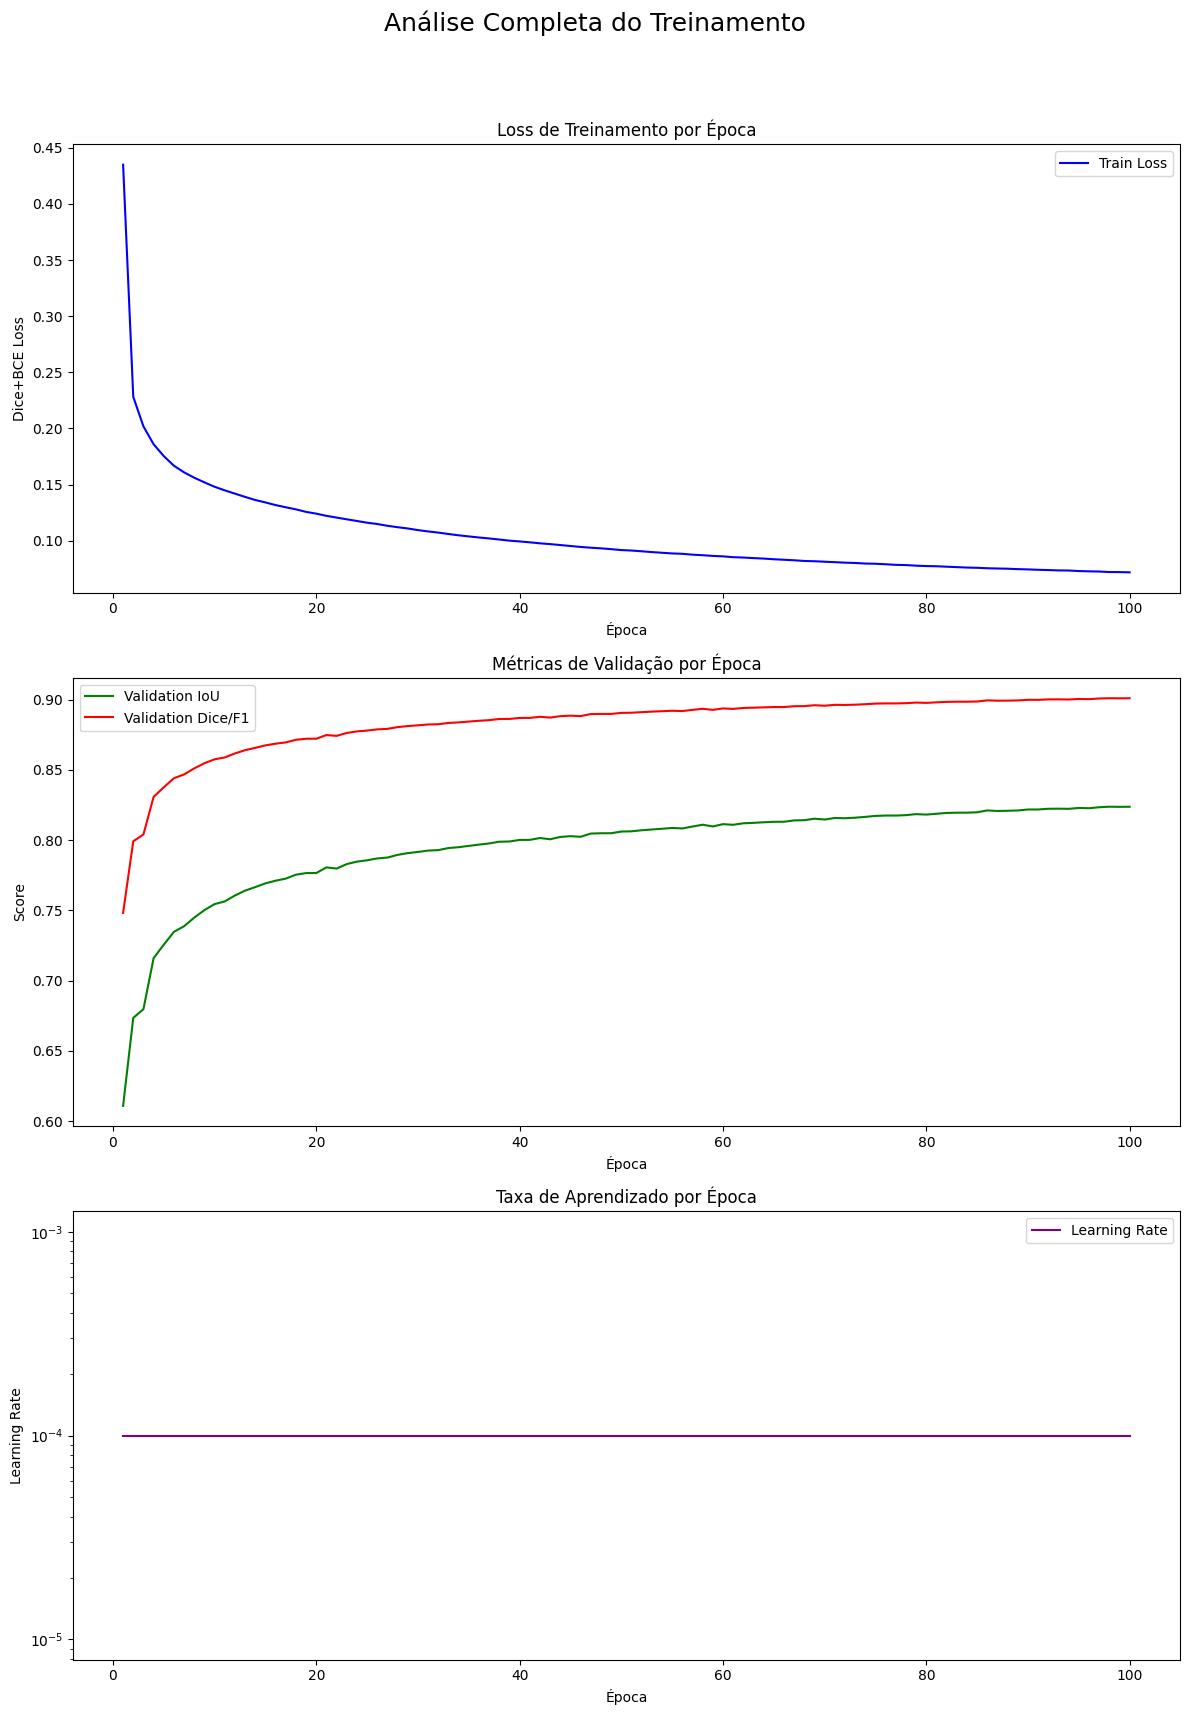


Calculando métricas finais detalhadas no conjunto de validação...


Calculando Métricas Finais: 100%|██████████| 2115/2115 [02:09<00:00, 16.39it/s]



      RESULTADOS FINAIS DO MELHOR MODELO
IoU         : 0.8238
Dice/F1     : 0.9011
Precision   : 0.9483
Recall      : 0.8600

Gerando visualizações de predições do melhor modelo...


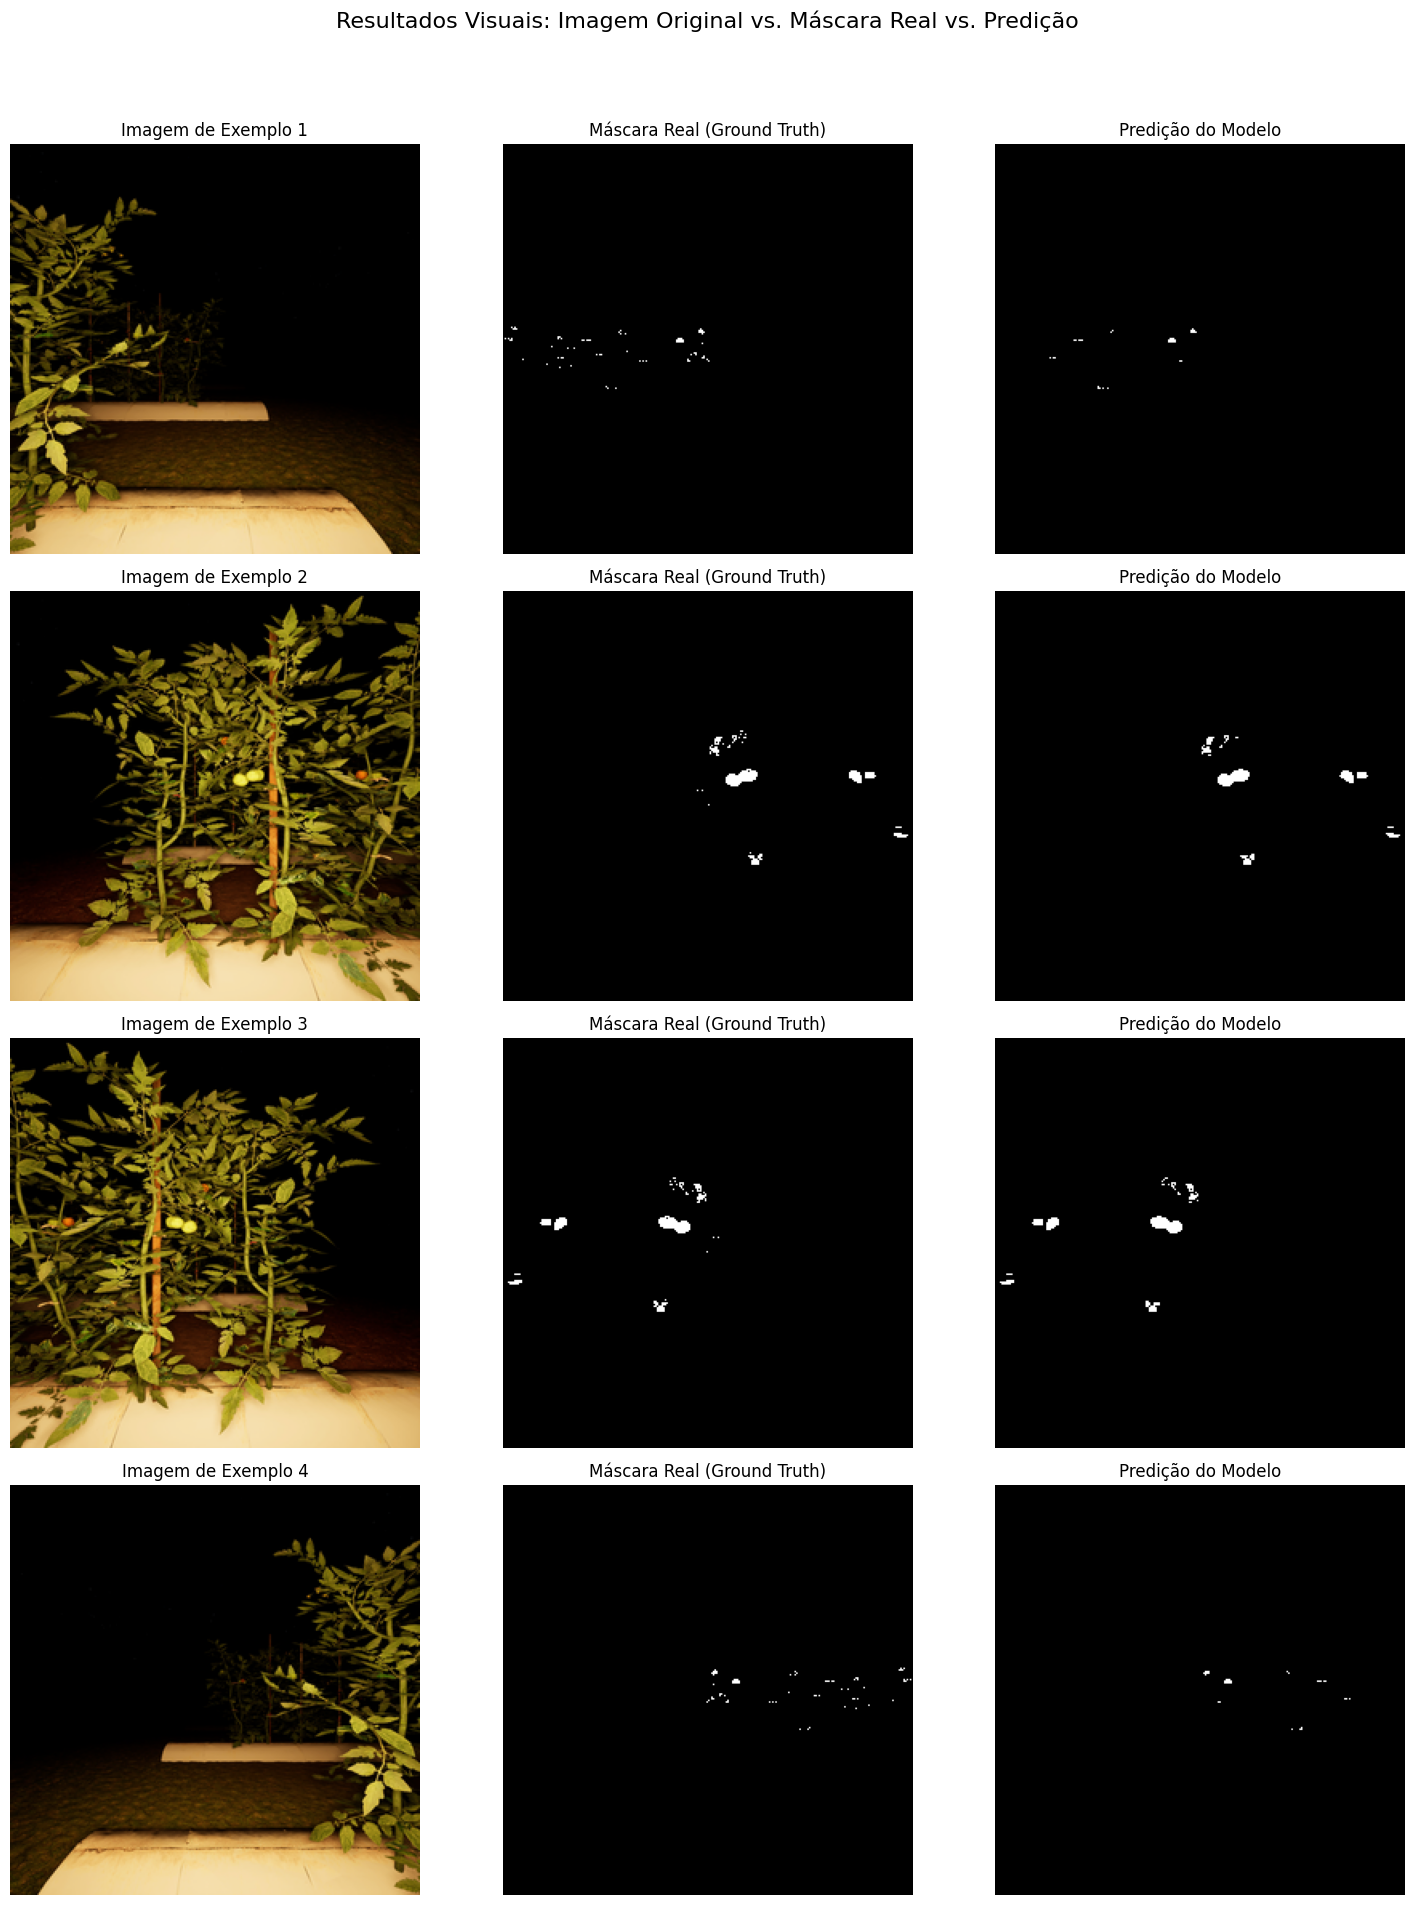

In [9]:
# ===================================================================
# CÉLULA 11: ANÁLISE FINAL, GRÁFICOS E MÉTRICAS (SUBSTITUIR)
# ===================================================================

# --- 1. CARREGAR DADOS E O MELHOR MODELO ---
print(f"Carregando o melhor modelo salvo de '{MODEL_SAVE_PATH}'...")
# Recria a arquitetura do modelo para carregar os pesos
analysis_model = UNET(in_channels=3, out_channels=1).to(DEVICE)
analysis_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
analysis_model.eval() # Coloca o modelo em modo de avaliação definitivo

print(f"Carregando log de treinamento de '{CSV_LOG_PATH}'...")
log_df = pd.read_csv(CSV_LOG_PATH)


# --- 2. GERAR GRÁFICOS DE TREINAMENTO ---
print("Gerando gráficos de treinamento...")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Análise Completa do Treinamento', fontsize=18)

# Gráfico 1: Loss de Treino
sns.lineplot(x='epoch', y='train_loss', data=log_df, ax=ax1, color='blue', label='Train Loss')
ax1.set_title('Loss de Treinamento por Época')
ax1.set_xlabel('Época')
ax1.set_ylabel('Dice+BCE Loss')

# Gráfico 2: Métricas de Validação
sns.lineplot(x='epoch', y='val_iou', data=log_df, ax=ax2, color='green', label='Validation IoU')
sns.lineplot(x='epoch', y='val_dice', data=log_df, ax=ax2, color='red', label='Validation Dice/F1')
ax2.set_title('Métricas de Validação por Época')
ax2.set_xlabel('Época')
ax2.set_ylabel('Score')
ax2.legend()

# Gráfico 3: Taxa de Aprendizado
sns.lineplot(x='epoch', y='learning_rate', data=log_df, ax=ax3, color='purple', label='Learning Rate')
ax3.set_title('Taxa de Aprendizado por Época')
ax3.set_xlabel('Época')
ax3.set_ylabel('Learning Rate')
ax3.set_yscale('log') # Escala logarítmica para ver melhor as quedas

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 3. CÁLCULO DE MÉTRICAS FINAIS DETALHADAS ---
def calculate_final_metrics(loader, model, device):
    print("\nCalculando métricas finais detalhadas no conjunto de validação...")
    dice_scores, iou_scores, precisions, recalls = [], [], [], []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Calculando Métricas Finais"):
            x, y = x.to(device), y.to(device)
            if len(y.shape) == 3: y = y.unsqueeze(1)
            
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            tp = (preds * y).sum()
            fp = ((1 - y) * preds).sum()
            fn = (y * (1 - preds)).sum()
            
            precision = (tp + 1e-6) / (tp + fp + 1e-6)
            recall = (tp + 1e-6) / (tp + fn + 1e-6)
            dice = (2 * tp + 1e-6) / (2 * tp + fp + fn + 1e-6)
            iou = (tp + 1e-6) / (tp + fp + fn + 1e-6)
            
            precisions.append(precision.item())
            recalls.append(recall.item())
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    final_metrics = {
        "IoU": np.mean(iou_scores),
        "Dice/F1": np.mean(dice_scores),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls)
    }
    return final_metrics

final_metrics = calculate_final_metrics(val_loader, analysis_model, DEVICE)


# --- 4. EXIBIR TABELA DE RESULTADOS FINAIS ---
print("\n" + "="*40)
print("      RESULTADOS FINAIS DO MELHOR MODELO")
print("="*40)
for metric, value in final_metrics.items():
    print(f"{metric:<12}: {value:.4f}")
print("="*40 + "\n")


# --- 5. VISUALIZAÇÃO QUALITATIVA DAS PREDIÇÕES ---
print("Gerando visualizações de predições do melhor modelo...")
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
val_images, val_masks = next(iter(val_loader))
num_images = min(5, len(val_images))

fig, axs = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
fig.suptitle('Resultados Visuais: Imagem Original vs. Máscara Real vs. Predição', fontsize=16)

for i in range(num_images):
    image_tensor = val_images[i].to(DEVICE)
    true_mask_np = val_masks[i].squeeze().cpu().numpy()
    
    with torch.no_grad():
        pred_mask = analysis_model(image_tensor.unsqueeze(0))
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask_np = (pred_mask > 0.5).float().squeeze().cpu().numpy()

    image_display = inv_normalize(image_tensor).cpu().permute(1, 2, 0).numpy()

    axs[i, 0].imshow(np.clip(image_display, 0, 1))
    axs[i, 0].set_title(f"Imagem de Exemplo {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(true_mask_np, cmap='gray')
    axs[i, 1].set_title("Máscara Real (Ground Truth)")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(pred_mask_np, cmap='gray')
    axs[i, 2].set_title("Predição do Modelo")
    axs[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()